# The only input needed to run everything is the `.h5` file!


## Imports

In [1]:
# To make sure we can import h5utils.py from the notebooks folder
import sys
sys.path.append('../')

import os
import shutil
import glob
import json
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm
import npyx

import plotly.graph_objects as go
import plotly.express as px

from io import BytesIO
import matplotlib.pyplot as plt
import base64

from IPython.display import clear_output

from datetime import date

from npyx.c4.plots_functions import C4_COLORS

%load_ext autoreload
%autoreload 2

cupy could not be imported - some functions dealing with the binary file (filtering, whitening...) will not work.
npyx version 2.8.5 imported.


<IPython.core.display.Javascript object>

In [2]:
# import warnings

# warnings.filterwarnings("ignore")

### Define paths

In [3]:
home = str(Path.home())
DATA_PATH = os.path.join(home, "Desktop", "C4_data_23_05_31")
PLOTS_SAVE_PATH = os.path.join(home, "Desktop", "dashboard_plots")

assert os.path.exists(DATA_PATH), "Please set DATA_PATH to the path of the data folder"

if not os.path.exists(PLOTS_SAVE_PATH):
    os.mkdir(PLOTS_SAVE_PATH)

HAUSSER_DATASET = "C4_data_23-04-27_hausser.h5"
HULL_DATASET = "C4_data_23_05_31_labeled_hull.h5"
LISBERGER_DATASET = "lisberger_neurons_2023_04_17.h5"

In [7]:
#! Important note: central range is set to 82 because that is the default for dsmatch
N_CHANNELS = 10
CENTRAL_RANGE = 90

# Need to adjust monkey data because it has a different sampling rate

In [8]:
dataset_path = os.path.join(DATA_PATH, HULL_DATASET)

In [9]:
MONKEY = "lisberger" in dataset_path
HULL = "labeled_hull" in dataset_path
if MONKEY:
    MONKEY_CENTRAL_RANGE = int(CENTRAL_RANGE * 40_000 / 30_000)

In [10]:
base_dataset = npyx.datasets.NeuronsDataset(
    dataset_path,
    quality_check=False if MONKEY else True,
    normalise_wvf=False,
    n_channels=N_CHANNELS,
    central_range=MONKEY_CENTRAL_RANGE if MONKEY else CENTRAL_RANGE,
    _use_amplitudes=True,
    _label="expert_label" if MONKEY else "ground_truth_label",
    _labels_only=True,
    _lisberger=True if MONKEY else False,
    _id_type="neuron_id" if MONKEY else "neuron_relative_id",
)

base_dataset.make_labels_only()

if MONKEY:
    base_dataset = npyx.datasets.resample_waveforms(base_dataset)

SAMPLING_RATE = base_dataset._sampling_rate

Reading dataset:   0%|          | 0/103 [00:00<?, ?it/s]

101 neurons loaded, of which labelled: 101 
2 neurons discarded, of which labelled: 2. More details at the 'discarded_df' attribute. 



# Dataset creation

## Extract features from `.h5` dataset

Feature dataset:

Create if new or load if existing

In [11]:
features_df = npyx.feat.h5_feature_extraction(
    base_dataset,
    _n_channels=N_CHANNELS,
    _central_range=MONKEY_CENTRAL_RANGE if MONKEY else CENTRAL_RANGE,
    _wvf_type="flipped",
    _sampling_rate=SAMPLING_RATE,
    _use_chanmap=False if MONKEY else True
    # ignore_exceptions=True,
)

Extracting features:   0%|          | 0/101 [00:00<?, ?it/s]

In [12]:
features_df

,label,dataset,unit,mfr,mifr,med_isi,mode_isi,prct5ISI,entropy,CV2_mean,...,onset_t,onset_amp,wvf_width,peak_trough_ratio,tau_recovery,multiplicative_a_recovery,repolarisation_slope,depolarisation_slope,spatial_decay_24um,dendritic_comp_amp
0,MFB,r1660_220816a_g1_loccar1_2,258,5.481487,146.601428,0.066200,0.001000,0.001467,7.514840,1.320218,...,2679,-27.544599,304,0.373013,1.097640,1.755252e+02,0.627595,-0.313136,0.187437,1.000000
1,MFB,r1660_220816a_g1_loccar1_2,261,18.966169,94.451778,0.033033,0.001000,0.002043,7.378163,0.858635,...,2747,-17.857579,304,0.436369,0.548887,1.629231e+02,0.625512,-0.327218,0.609913,1.000000
2,MFB,r1660_220816a_g1_loccar1_2,528,28.849560,229.865535,0.009267,0.001000,0.001167,7.578367,1.164803,...,2846,-20.703388,405,0.236953,6.353658,1.416218e+02,0.374333,-0.392955,0.437921,0.000000
3,MFB,r1660_220816a_g1_loccar1_2,189,9.580792,204.881860,0.023167,0.001000,0.001133,7.541193,1.233346,...,2791,-6.535144,404,0.719139,2.961552,1.200130e+02,0.305901,-0.407954,0.435644,0.188379
4,MFB,r1660_220816a_g1_loccar1_2,545,30.296084,335.080751,0.003833,0.001000,0.001100,7.195921,0.916085,...,2825,-12.487171,607,0.187328,6.473581,5.029655e+01,0.280964,-0.311007,0.164939,0.227686
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
96,PkC_ss,r1651_220629g0,32,103.916905,123.402087,0.008567,0.006129,0.004700,6.687571,0.405858,...,2670,-19.022428,708,0.342324,11.150286,1.188101e+02,0.258045,-0.257527,0.559987,0.086139
97,PkC_cs,r1651_220629g0,26,1.193771,3.721627,0.501600,0.125083,0.083550,6.436856,0.940223,...,394,-11.618986,607,0.931524,660.573967,8.328283e+03,0.332226,-0.288713,0.539408,0.000000
98,MLI,r1651_220706g0,176,30.079192,63.773662,0.021000,0.013147,0.006300,6.981460,0.600650,...,2354,-7.004856,1517,0.647011,59.389394,3.638799e+02,0.137149,-0.128299,0.226828,1.000000
99,PkC_ss,r1651_220706g0,49,177.517112,202.649996,0.004933,0.004564,0.003200,6.680983,0.208073,...,2120,-30.422850,1214,0.394538,20.883143,2.147623e+02,0.160813,-0.161054,0.484086,0.000000


# Plotting dataset:

In [13]:
if HULL:
    extra_abs_id = "101"
elif MONKEY:
    extra_abs_id = "201"
else:
    extra_abs_id = ""

In [14]:
def make_plotting_df(
    df: pd.DataFrame,
    save: bool = True,
    save_path: str = None,
    extra_abs_id: str = "",
) -> pd.DataFrame:
    dataframe = df.copy()

    colors_dict = C4_COLORS

    # Add an 'absolute id' like column for plotting purposes, so that each neuron has an unique identifier
    abs_id = np.arange(len(dataframe))

    #! Mind this hacky thing
    abs_id = np.array([extra_abs_id + str(x) for x in abs_id], dtype=int)
    dataframe.insert(loc=0, column="plotting_id", value=abs_id)

    new_df = pd.DataFrame(
        columns=[
            "label",
            "feature",
            "normalised_value",
            "raw_value",
            "dataset",
            "unit",
            "color",
            "plotting_id",
        ]
    )

    # Why the hard-coded 4? The first 4 columns in the df are metadata (dataset, unit, plotting_id, label)
    for i, column in enumerate(dataframe.columns[4:]):
        mean_data = (dataframe[column].to_numpy()).mean()
        std_data = (dataframe[column].to_numpy()).std()
        norm_data = (dataframe[column].to_numpy() - mean_data) / std_data
        raw_data = dataframe[column].to_numpy()
        labels = dataframe["label"].to_numpy()
        feature = [dataframe.columns[i + 4]] * len(norm_data)
        dataset = dataframe["dataset"].to_numpy()
        unit = dataframe["unit"].to_numpy()
        color = [f"rgb{tuple(colors_dict[label])}" for label in labels]
        plotting_id = dataframe["plotting_id"].to_numpy()

        feat_df = pd.DataFrame(
            {
                "label": labels,
                "feature": feature,
                "normalised_value": norm_data,
                "raw_value": raw_data,
                "dataset": dataset,
                "unit": unit,
                "color": color,
                "plotting_id": plotting_id,
            }
        )
        new_df = pd.concat([new_df, feat_df], ignore_index=True)

    # Finally assign color grey to neurons with invalid temporal features
    zero_temporal = new_df[new_df["raw_value"] == 0.0]["unit"].value_counts()
    zero_units = (zero_temporal[zero_temporal > 5]).index.to_numpy()
    new_df.loc[new_df["unit"].isin(zero_units), "color"] = "gray"

    # Save if the option is requested
    if save:
        if MONKEY:
            lab = "lisberger"
        elif HULL:
            lab = "hull"
        else:
            lab = "hausser"
        today = date.today().strftime("%b-%d-%Y")
        if save_path is None:
            new_df.to_csv(f"{today}_{lab}_dashboard_features.csv")
        else:
            new_df.to_csv(f"{save_path}/{today}_{lab}_dashboard_features.csv")

    return new_df

In [15]:
all_features = make_plotting_df(features_df, extra_abs_id=extra_abs_id)

In [13]:
all_features

,label,feature,normalised_value,raw_value,dataset,unit,color,plotting_id
0,PkC_ss,mfr,2.499944,152.144319,18-08-30_YC001_probe1,431,"(28, 120, 181)",0
1,PkC_ss,mfr,2.915929,171.144416,18-08-30_YC001_probe1,437,"(28, 120, 181)",1
2,PkC_ss,mfr,0.676488,68.858097,18-08-30_YC001_probe1,487,"(28, 120, 181)",2
3,PkC_ss,mfr,0.550317,63.095284,18-08-30_YC001_probe1,492,"(28, 120, 181)",3
4,PkC_ss,mfr,0.720874,70.885445,18-08-30_YC001_probe1,494,"(28, 120, 181)",4
...,...,...,...,...,...,...,...,...
4175,GoC,dendritic_comp_amp,NaN,0.000000,23-02-13_HS15,191,"(56, 174, 62)",105
4176,GoC,dendritic_comp_amp,NaN,0.000000,23-02-13_HS15,195,"(56, 174, 62)",106
4177,GoC,dendritic_comp_amp,NaN,0.000000,23-02-13_HS15,208,"(56, 174, 62)",107
4178,GoC,dendritic_comp_amp,NaN,0.000000,23-02-13_HS15,218,"(56, 174, 62)",108


## Plots generation

Includes: waveforms, acgs, features plots and amplitude plots.

In [16]:
def save_acg(spike_train, unit_n, save_name=None):
    if save_name is None:
        raise NotImplementedError("Please specify a save name")

    # Get the spike train in the spontaneous period that meets false positive and false negative criteria.

    if len(spike_train.ravel()) > 1:
        plt.figure()
        npyx.plot.plot_acg("hello", unit_n, train=spike_train, figsize=(5, 4.5))

        plt.savefig(f"{save_name}-acg.pdf", format="pdf")
        plt.close()
    else:
        fig = plt.figure()
        ax = fig.add_subplot()
        fig.subplots_adjust(top=0.85)
        ax.axis([0, 10, 0, 10])
        ax.text(
            3,
            5,
            "No usable train \n after quality checks",
            style="italic",
            bbox={"facecolor": "red", "alpha": 0.4, "pad": 10},
        )
        plt.savefig(f"{save_name}-acg.pdf", format="pdf", bbox_inches="tight")
        plt.close()


def save_wvf(waveform, save_name=None):
    if save_name is None:
        raise NotImplementedError("Please specify a save name")

    # Undo the waveform padding that is done inside the class
    waveform = np.unique(waveform, axis=1)

    plt.figure()
    npyx.plot.plt_wvf(waveform, figh_inch=6, figw_inch=5)

    plt.savefig(f"{save_name}-wvf.pdf", format="pdf", bbox_inches="tight")
    plt.close()


def save_feat(waveform, save_name=None):
    plt.rcParams["figure.figsize"] = [3.50, 2.50]
    plt.rcParams["figure.autolayout"] = True

    if save_name is None:
        raise NotImplementedError("Please specify a save name")

    if waveform.ndim == 1:
        wave = waveform
    else:
        wave, somatic, channel = npyx.feat.find_relevant_waveform(
            waveform,
            np.arange(len(waveform)),
            None,
            np.ones(len(waveform)).astype(bool),
        )

    plt.figure()
    npyx.feat.plot_all_features(wave)

    plt.savefig(f"{save_name}-feat.pdf", format="pdf", bbox_inches="tight")
    plt.close()


def save_amplitudes(times, amplitudes, dpi=300, save_name=None):
    if save_name is None:
        raise NotImplementedError("Please specify a save name")

    #! Hacky duplicate handling (should be fixed in npyx)!!!
    if len(times) > len(amplitudes):
        duplicate_times = npyx.spk_t.duplicates_mask(times, enforced_rp=1)
        times = times[~duplicate_times]
    if len(amplitudes) > len(times):
        amplitudes = amplitudes[: len(times)]

    fig, ax = plt.subplots(
        1, 2, figsize=(12, 5), sharey=True, gridspec_kw={"width_ratios": [3, 1]}
    )
    ax[0].plot(
        times / (30000 * 60), amplitudes, marker="o", markersize=2, linestyle="None"
    )
    ax[0].set_xlabel("Time (min)")
    ax[0].set_ylabel(r"Amplitude ($\mu$V)")
    ax[0].spines["top"].set_visible(False)
    ax[0].spines["right"].set_visible(False)

    ax[1].hist(amplitudes, bins=200, orientation="horizontal")
    ax[1].set_xlabel("Count")
    ax[1].spines["top"].set_visible(False)
    ax[1].spines["right"].set_visible(False)
    plt.tight_layout()
    plt.savefig(
        f"{save_name}-amplitudes.png", format="png", dpi=dpi, bbox_inches="tight"
    )
    plt.close()

In [17]:
for plotting_id in tqdm(all_features["plotting_id"].unique()):
    save_id = plotting_id
    save_name = str(os.path.join(PLOTS_SAVE_PATH, str(save_id)))
    plotting_id = int(str(plotting_id)[3:]) if (MONKEY or HULL) else int(plotting_id)
    spike_train = base_dataset.spikes_list[plotting_id]
    waveform = base_dataset.wf[plotting_id].reshape(N_CHANNELS, CENTRAL_RANGE)
    conformed_waveform = base_dataset.conformed_waveforms[plotting_id]
    amplitudes = base_dataset.amplitudes_list[plotting_id]
    save_acg(spike_train, int(plotting_id), save_name=save_name)
    save_wvf(waveform.T, save_name=save_name)
    save_feat(conformed_waveform, save_name=save_name)
    save_amplitudes(spike_train, amplitudes, save_name=save_name)
    plt.close("all")
# clear_output(wait=True)

  0%|          | 0/101 [00:00<?, ?it/s]

In [ ]:
raise AssertionError("Stop")

# Alternative opto plot scripts:

Re-calculates the opto-plots for every neuron in the json file and saves it locally here.

In [ ]:
def re_plot_opto_plots(json_path, overwrite=False):
    with open(json_path) as f:
        json_f = json.load(f)

    # Check the json and do the optoplots at the same time
    for dataset in tqdm(json_f.values(), desc="Re-plotting opto plots"):
        data_path = dataset["dp"]
        dp = Path(data_path)

        if not dp.exists():
            print(f"\033[31;1m{dp} doesn't exist!!\033[0m")
            continue

        units = dataset["units"]
        ss = dataset["ss"]
        cs = dataset["cs"]
        all_units = units + ss + cs
        all_units_str = " ".join(map(str, all_units))

        if "YC012" in data_path:
            animal_name = "YC012"
        elif "MO027" in data_path:
            animal_name = "MO027"
        elif "MO042" in data_path:
            animal_name = "MO042"
        else:
            animal_name = data_path.split("/")[-2].split("_")[-1]

        script_path = "/home/npyx/Dropbox/Notebooks/scripts/50ms-plots-faster.py"
        fig_dir = "/home/npyx/Dropbox/Notebooks/individual-plots"

        new_optoplots.make_plots(
            data_path,
            fig_dir,
            animal_name,
            1,
            np.array(all_units),
            "opto_plots",
            overwrite=overwrite,
        )

        # os.system(f"conda run -n npyx python {script_path} -dp '{data_path}' -save-dir 'opto_plots' -fig-dir '{fig_dir}' -mouse '{animal_name}' -startstim 1 -which 'good' --units {all_units_str}")

In [ ]:
re_plot_opto_plots(json_path)

## Generate SVG files and move them to desktop

In [18]:
home = str(Path.home())

# if not os.path.isdir(f"{home}/Desktop/SVGs_SfN"):
#     os.mkdir(f"{home}/Desktop/SVGs_SfN")

os.chdir(PLOTS_SAVE_PATH)

for file in tqdm(glob.glob("*.pdf")):
    filename = file.split(".")[0]
    if "opto_plots" in file:
        os.system(f"convert -units PixelsPerInch -density 288 {file} {filename}.png ")
        # os.system(f"mv {filename}.png {home}/Desktop/SVGs_SfN")
    else:
        os.system(f"pdf2svg {file} {filename}_big.svg 1")
        os.system(f"svgo {filename}_big.svg -o {filename}.svg")
        os.system(f"rm {filename}_big.svg")
        # os.system(f"mv {filename}.svg {home}/Desktop/SVGs_SfN")

  0%|          | 0/2637 [00:00<?, ?it/s]


201110-wvf_big.svg:
Done in 117 ms!
40.367 KiB - 52.6% = 19.14 KiB

201317-wvf_big.svg:
Done in 176 ms!
45.847 KiB - 52.4% = 21.833 KiB

201274-feat_big.svg:
Done in 199 ms!
52.014 KiB - 45.9% = 28.146 KiB

201552-feat_big.svg:
Done in 221 ms!
56.404 KiB - 45.1% = 30.975 KiB

201282-acg_big.svg:
Done in 164 ms!
39.455 KiB - 43.2% = 22.421 KiB

201445-acg_big.svg:
Done in 164 ms!
38.743 KiB - 42.5% = 22.262 KiB

201545-feat_big.svg:
Done in 228 ms!
55.848 KiB - 45.3% = 30.557 KiB

20116-wvf_big.svg:
Done in 132 ms!
40.329 KiB - 53% = 18.944 KiB

39-acg_big.svg:
Done in 218 ms!
75.932 KiB - 56.4% = 33.117 KiB

20169-feat_big.svg:
Done in 244 ms!
56.826 KiB - 45% = 31.274 KiB

201365-feat_big.svg:
Done in 244 ms!
57.008 KiB - 44.9% = 31.408 KiB

201138-acg_big.svg:
Done in 220 ms!
79.619 KiB - 57.3% = 33.994 KiB

104-wvf_big.svg:
Done in 137 ms!
43.709 KiB - 53.3% = 20.404 KiB

201443-acg_big.svg:
Done in 242 ms!
74.149 KiB - 56.6% = 32.202 KiB

10142-wvf_big.svg:
Done in 162 ms!
45.916 

## Filter PkC CS and SS pairs that are not optotagged

In [ ]:
with open(json_path) as f:
    json_f = json.load(f)
simple_and_complex = []
for key in json_f:
    simple_and_complex.extend(json_f[key]["ss"])
    simple_and_complex.extend(json_f[key]["cs"])

In [ ]:
not_optotagged = df.loc[
    df["unit"].isin(simple_and_complex), ["label", "dp", "unit", "plotting_id"]
]

In [ ]:
today = date.today().strftime("%b-%d-%Y")
not_optotagged.to_csv(f"{today}-not_optotagged.csv")

### Here manual curation is needed to add the corresponding pairs to the json file!
See [here](https://docs.google.com/spreadsheets/d/14-IJPxhNrgPPapYODdag7BbuVSprwdH8q35Z2QVaG_Y/edit#gid=1741211396)

After editing manually we can remove the non optotagged optoplots and change them for what we actually want

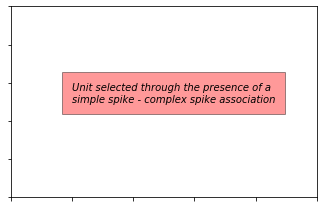

In [ ]:
fig = plt.figure(figsize=(4.6, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)
ax.axis([0, 10, 0, 10])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(
    2,
    5,
    "Unit selected through the presence of a \n"
    "simple spike - complex spike association",
    style="italic",
    bbox={"facecolor": "red", "alpha": 0.4, "pad": 10},
)
# plt.show()
plt.savefig("purkinje_cell.pdf", format="pdf")

In [ ]:
os.system(
    f"convert -units PixelsPerInch -density 288 purkinje_cell.pdf purkinje_cell.png "
)
os.system(f"mv purkinje_cell.png {home}/Desktop/SVGs_SfN")

0

In [ ]:
# Remove opto plots of non light responsive cells
for i, row in not_optotagged.iterrows():
    unit = row["unit"]
    plotting_id = str(row["plotting_id"])
    os.system(f"rm {plotting_id}_opto_plots_combined.pdf")
    fig = plt.figure(figsize=(4.6, 3))
    ax = fig.add_subplot()
    fig.subplots_adjust(top=0.85)
    ax.axis([0, 10, 0, 10])
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    ax.text(
        2,
        5,
        "Unit selected through the presence of a \n"
        "simple spike - complex spike association",
        style="italic",
        bbox={"facecolor": "red", "alpha": 0.4, "pad": 10},
    )
    pdf_file = f"{plotting_id}_opto_plots_combined.pdf"
    filename = f"{plotting_id}_opto_plots_combined"
    plt.savefig(pdf_file, format="pdf")
    plt.close()
    os.system(f"convert -units PixelsPerInch -density 288 {pdf_file} {filename}.png ")
    os.system(f"mv {filename}.png {home}/Desktop/SVGs_SfN")

rm: cannot remove '103_opto_plots_combined.pdf': No such file or directory
rm: cannot remove '104_opto_plots_combined.pdf': No such file or directory
rm: cannot remove '105_opto_plots_combined.pdf': No such file or directory
rm: cannot remove '106_opto_plots_combined.pdf': No such file or directory


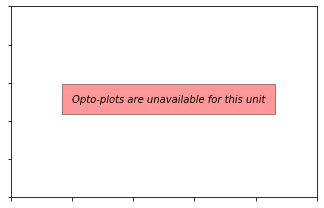

In [ ]:
fig = plt.figure(figsize=(4.6, 3))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)
ax.axis([0, 10, 0, 10])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(
    2,
    5,
    "Opto-plots are unavailable for this unit",
    style="italic",
    bbox={"facecolor": "red", "alpha": 0.4, "pad": 10},
)
plt.savefig("opto_plots_unavailable.pdf", format="pdf")

Text(3, 5, 'Waveform features could not be computed for this unit.')

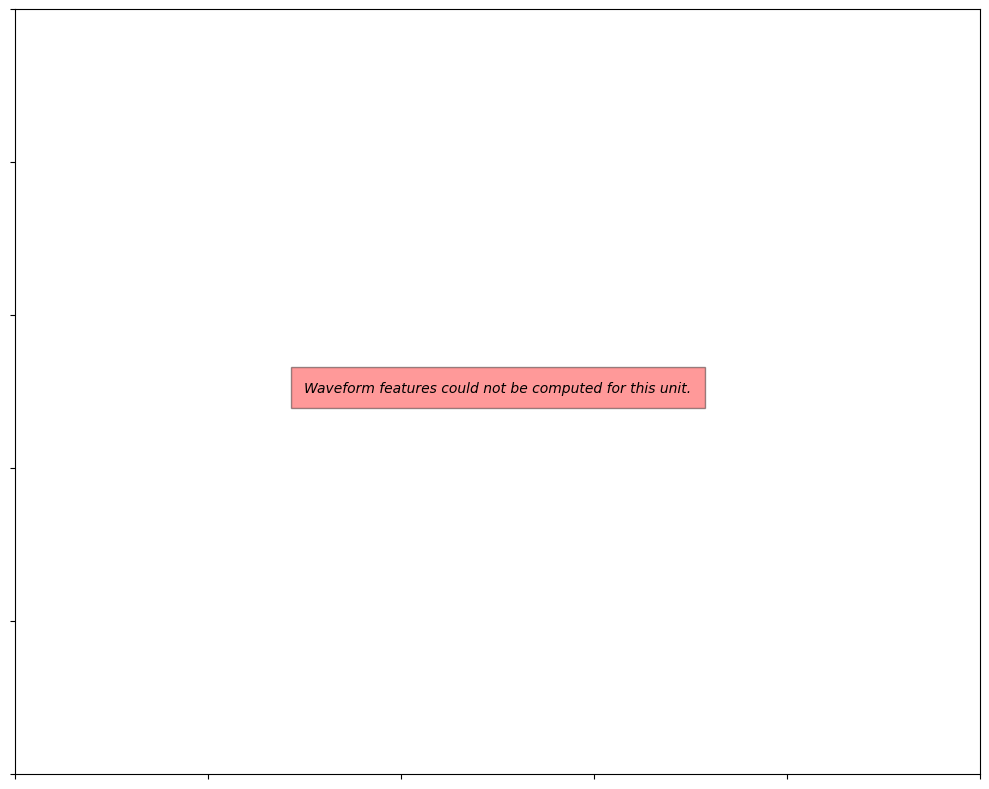

In [ ]:
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot()
fig.subplots_adjust(top=0.85)
ax.axis([0, 10, 0, 10])
ax.set_xticklabels([])
ax.set_yticklabels([])
ax.text(
    3,
    5,
    "Waveform features could not be computed for this unit.",
    style="italic",
    bbox={"facecolor": "red", "alpha": 0.4, "pad": 10},
)

---

# Join datasets

In [2]:
df_hausser = pd.read_csv(
    "datasets/Jul-28-2023_hausser_dashboard_features.csv", index_col=0
)

In [3]:
df_hausser

,label,feature,normalised_value,raw_value,dataset,unit,color,plotting_id
0,PkC_ss,mfr,2.499944,152.144319,18-08-30_YC001_probe1,431,"(28, 120, 181)",0
1,PkC_ss,mfr,2.915929,171.144416,18-08-30_YC001_probe1,437,"(28, 120, 181)",1
2,PkC_ss,mfr,0.676488,68.858097,18-08-30_YC001_probe1,487,"(28, 120, 181)",2
3,PkC_ss,mfr,0.550317,63.095284,18-08-30_YC001_probe1,492,"(28, 120, 181)",3
4,PkC_ss,mfr,0.720874,70.885445,18-08-30_YC001_probe1,494,"(28, 120, 181)",4
...,...,...,...,...,...,...,...,...
4175,GoC,dendritic_comp_amp,NaN,0.000000,23-02-13_HS15,191,"(56, 174, 62)",105
4176,GoC,dendritic_comp_amp,NaN,0.000000,23-02-13_HS15,195,"(56, 174, 62)",106
4177,GoC,dendritic_comp_amp,NaN,0.000000,23-02-13_HS15,208,"(56, 174, 62)",107
4178,GoC,dendritic_comp_amp,NaN,0.000000,23-02-13_HS15,218,"(56, 174, 62)",108


In [7]:
df_hull = pd.read_csv("datasets/Jul-28-2023_hull_dashboard_features.csv", index_col=0)

In [8]:
df_hull

,label,feature,normalised_value,raw_value,dataset,unit,color,plotting_id
0,MFB,mfr,-0.780220,5.481487,r1660_220816a_g1_loccar1_2,258,"(214, 37, 41)",1010
1,MFB,mfr,-0.532697,18.966169,r1660_220816a_g1_loccar1_2,261,"(214, 37, 41)",1011
2,MFB,mfr,-0.351279,28.849560,r1660_220816a_g1_loccar1_2,528,"(214, 37, 41)",1012
3,MFB,mfr,-0.704974,9.580792,r1660_220816a_g1_loccar1_2,189,"(214, 37, 41)",1013
4,MFB,mfr,-0.324727,30.296084,r1660_220816a_g1_loccar1_2,545,"(214, 37, 41)",1014
...,...,...,...,...,...,...,...,...
3833,PkC_ss,dendritic_comp_amp,-0.682310,0.086139,r1651_220629g0,32,"(28, 120, 181)",10196
3834,PkC_cs,dendritic_comp_amp,-0.911330,0.000000,r1651_220629g0,26,"(0, 0, 0)",10197
3835,MLI,dendritic_comp_amp,1.747409,1.000000,r1651_220706g0,176,"(224, 85, 159)",10198
3836,PkC_ss,dendritic_comp_amp,-0.911330,0.000000,r1651_220706g0,49,"(28, 120, 181)",10199


In [9]:
df_lisberger = pd.read_csv(
    "datasets/Jul-27-2023_lisberger_dashboard_features.csv", index_col=0
)

In [10]:
df_lisberger

,label,feature,normalised_value,raw_value,dataset,unit,color,plotting_id
0,PkC_ss,mfr,2.333733,106.173130,2022_01_11_Dandy,0,"(28, 120, 181)",2010
1,PkC_ss,mfr,1.022180,64.164396,2022_01_13_Dandy,1,"(28, 120, 181)",2011
2,PkC_cs,mfr,-0.940860,1.288686,2022_01_13_Dandy,2,"(0, 0, 0)",2012
3,PkC_ss,mfr,2.295850,104.959761,2022_01_13_Dandy_2,3,"(28, 120, 181)",2013
4,MFB,mfr,-0.320536,21.157504,2022_01_21_Dandy,5,"(214, 37, 41)",2014
...,...,...,...,...,...,...,...,...
25379,GoC,dendritic_comp_amp,NaN,0.000000,Yoda_2020_08_24,1138,"(56, 174, 62)",201663
25380,GoC,dendritic_comp_amp,NaN,0.000000,Yoda_2020_08_24,1139,"(56, 174, 62)",201664
25381,GoC,dendritic_comp_amp,NaN,0.000000,Yoda_2020_08_25,1141,"(56, 174, 62)",201665
25382,GoC,dendritic_comp_amp,NaN,0.000000,Yoda_2020_08_25,1142,"(56, 174, 62)",201666


In [11]:
df_hull["lab"] = "hull"
df_hausser["lab"] = "hausser"
df_lisberger["lab"] = "lisberger"

In [12]:
combined_df = pd.concat([df_hull, df_hausser, df_lisberger])

In [13]:
combined_df

,label,feature,normalised_value,raw_value,dataset,unit,color,plotting_id,lab
0,MFB,mfr,-0.780220,5.481487,r1660_220816a_g1_loccar1_2,258,"(214, 37, 41)",1010,hull
1,MFB,mfr,-0.532697,18.966169,r1660_220816a_g1_loccar1_2,261,"(214, 37, 41)",1011,hull
2,MFB,mfr,-0.351279,28.849560,r1660_220816a_g1_loccar1_2,528,"(214, 37, 41)",1012,hull
3,MFB,mfr,-0.704974,9.580792,r1660_220816a_g1_loccar1_2,189,"(214, 37, 41)",1013,hull
4,MFB,mfr,-0.324727,30.296084,r1660_220816a_g1_loccar1_2,545,"(214, 37, 41)",1014,hull
...,...,...,...,...,...,...,...,...,...
25379,GoC,dendritic_comp_amp,NaN,0.000000,Yoda_2020_08_24,1138,"(56, 174, 62)",201663,lisberger
25380,GoC,dendritic_comp_amp,NaN,0.000000,Yoda_2020_08_24,1139,"(56, 174, 62)",201664,lisberger
25381,GoC,dendritic_comp_amp,NaN,0.000000,Yoda_2020_08_25,1141,"(56, 174, 62)",201665,lisberger
25382,GoC,dendritic_comp_amp,NaN,0.000000,Yoda_2020_08_25,1142,"(56, 174, 62)",201666,lisberger


In [14]:
combined_mean = (
    combined_df[combined_df["lab"].isin(["hull", "hausser"])]
    .groupby("feature")["raw_value"]
    .mean()
)
combined_std = (
    combined_df[combined_df["lab"].isin(["hull", "hausser"])]
    .groupby("feature")["raw_value"]
    .std()
)

re_norm_features = []
for i, row in combined_df.iterrows():
    if row["lab"] in ["hull", "hausser"]:
        feature = row["feature"]
        feature_mean = combined_mean[feature]
        feature_std = combined_std[feature]

        re_normalised_feature = (row["raw_value"] - feature_mean) / feature_std
        re_norm_features.append(re_normalised_feature)
    else:
        re_norm_features.append(row["normalised_value"])

In [15]:
len(re_norm_features)

33402

In [16]:
combined_df["joint_normalised_value"] = re_norm_features

In [17]:
combined_df

,label,feature,normalised_value,raw_value,dataset,unit,color,plotting_id,lab,joint_normalised_value
0,MFB,mfr,-0.780220,5.481487,r1660_220816a_g1_loccar1_2,258,"(214, 37, 41)",1010,hull,-0.738877
1,MFB,mfr,-0.532697,18.966169,r1660_220816a_g1_loccar1_2,261,"(214, 37, 41)",1011,hull,-0.471599
2,MFB,mfr,-0.351279,28.849560,r1660_220816a_g1_loccar1_2,528,"(214, 37, 41)",1012,hull,-0.275703
3,MFB,mfr,-0.704974,9.580792,r1660_220816a_g1_loccar1_2,189,"(214, 37, 41)",1013,hull,-0.657625
4,MFB,mfr,-0.324727,30.296084,r1660_220816a_g1_loccar1_2,545,"(214, 37, 41)",1014,hull,-0.247031
...,...,...,...,...,...,...,...,...,...,...
25379,GoC,dendritic_comp_amp,NaN,0.000000,Yoda_2020_08_24,1138,"(56, 174, 62)",201663,lisberger,NaN
25380,GoC,dendritic_comp_amp,NaN,0.000000,Yoda_2020_08_24,1139,"(56, 174, 62)",201664,lisberger,NaN
25381,GoC,dendritic_comp_amp,NaN,0.000000,Yoda_2020_08_25,1141,"(56, 174, 62)",201665,lisberger,NaN
25382,GoC,dendritic_comp_amp,NaN,0.000000,Yoda_2020_08_25,1142,"(56, 174, 62)",201666,lisberger,NaN


In [18]:
combined_df.to_csv("Jul-28-combined_dashboard.csv")